# CS 39AA - Notebook 11a: Airline Tweets MLP w/ Word Embeddings

We've started talking about word embeddings; what they are as well as how we both create and use them. We'll now see what it looks like to load and use pre-made embeddings on the Airline Tweet dataset. 

The word embeddings we'll use are going to be the GloVe embeddings. There are several sets of GloVe embeddings that were created. The smallest has a vocabulary of 400k tokens/words with each embedding represented by a 50-element vector (50d). The largest has a vocabulary of over 2M tokens/words with each embedding being a 300-element vector (300d). On top of that, the embeddings were created with different datasets. So, depending on your use case you may want to use embeddings with a different vocabulary size, different embedding size, and/or created using a different dataset. You can read more about the GloVe embedding here: 
*  [https://nlp.stanford.edu/projects/glove/](https://nlp.stanford.edu/projects/glove/)


We'll use the smallest set of embeddings and with the smallest vector sizes. This set of embeddings is downloaded in a zip file with the 100d, 200d, and 300d sets of embeddings, which altogether is over 800Mb in size. So, for practical reasons, you'll probably want to run this locally where you have more storage. 


In [178]:
import torch
import random
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics.functional import pairwise_cosine_similarity
from tqdm import notebook

In [179]:
import torchtext as text
vec = text.vocab.GloVe(name='6B', dim=50)

Load the airline tweets and prepare to load embeddings for each tweet. 

In [180]:
examples = ['annoy', 'annoyed', 'disappointed', 'sad', 'happy', 'pilot', 'attendant', 'crew', 'suitcase', 'backpack', 'carryon']
embeddings = vec.get_vecs_by_tokens(examples, lower_case_backup=True)
embeddings

tensor([[ 2.3457e-01, -4.7683e-01,  6.3459e-01, -3.6475e-01, -2.1981e-01,
         -4.5539e-01,  7.0779e-01,  1.0140e+00, -9.1157e-01,  4.6997e-01,
         -2.2969e-01,  6.6490e-01,  7.6746e-01, -1.0760e-01,  3.6551e-03,
          8.9326e-01, -9.5184e-02, -5.2423e-02,  8.8386e-01, -4.9152e-01,
         -3.5541e-01, -1.9993e-01,  1.9838e-02,  8.1985e-01,  1.0315e+00,
         -6.9975e-01, -2.9327e-01, -4.7181e-01,  8.7062e-01, -1.0971e+00,
         -6.3421e-01,  1.1884e+00, -3.3743e-02, -3.8841e-01, -4.6839e-01,
          8.8104e-02, -1.6746e-01, -4.0789e-01, -3.7836e-01, -1.4252e-01,
          2.0980e-01,  1.7340e-01,  1.9545e-01,  6.8907e-01,  1.0228e+00,
          2.3531e-01,  1.9601e-01, -2.6078e-01, -8.8978e-02,  5.7906e-01],
        [ 1.9271e-01, -9.8134e-01, -1.9098e-01, -6.1861e-01,  2.4468e-02,
         -2.0539e-01, -2.0984e-01,  1.0406e+00, -1.0876e+00,  1.1150e-01,
          2.6504e-01,  2.1416e-01,  5.5952e-02, -1.3927e-01,  5.4169e-01,
          5.0256e-01, -2.6933e-01,  3

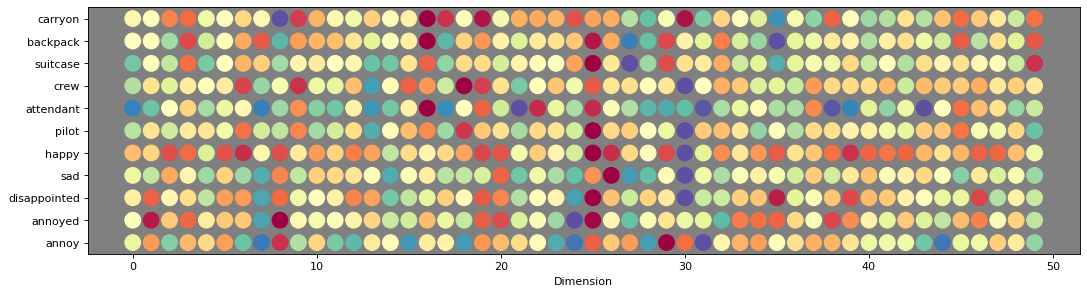

In [181]:
def compare_words_with_colors(vecs, wds):
    wdsr = wds[:]
    wdsr.reverse()
        
    dim = len(vecs[0])
    
    fig = plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    ax.set_facecolor('gray')
    
    for i,v in enumerate(vecs):
        ax.scatter(range(dim),[i]*dim, c=vecs[i], cmap='Spectral', s=200)
    
    #plt.xticks(range(n), [i+1 for i in range(n)])
    plt.xlabel('Dimension')
    plt.yticks(range(len(wds)), wds)
    
    plt.show()

compare_words_with_colors(embeddings, examples)
#examples.reverse()

In [182]:
similarities = pairwise_cosine_similarity(embeddings, zero_diagonal=False)
distances = 1 - similarities 
distances

pairwise_top = pd.DataFrame(
    distances,
    columns = examples,
    index = examples
)

distances
#similarities


tensor([[1.1921e-07, 4.3455e-01, 7.1622e-01, 7.6653e-01, 7.2499e-01, 1.1374e+00,
         8.8526e-01, 1.1141e+00, 1.0229e+00, 9.7518e-01, 9.6831e-01],
        [4.3455e-01, 5.9605e-08, 2.5124e-01, 5.1642e-01, 4.5671e-01, 8.4883e-01,
         7.4169e-01, 8.7239e-01, 1.0158e+00, 1.0266e+00, 1.0706e+00],
        [7.1622e-01, 2.5124e-01, 0.0000e+00, 4.2236e-01, 2.3252e-01, 7.4722e-01,
         8.3502e-01, 6.9937e-01, 1.0674e+00, 1.1509e+00, 1.2325e+00],
        [7.6653e-01, 5.1642e-01, 4.2236e-01, 0.0000e+00, 3.1094e-01, 8.3679e-01,
         7.3417e-01, 8.0400e-01, 8.8330e-01, 9.4015e-01, 1.1652e+00],
        [7.2499e-01, 4.5671e-01, 2.3252e-01, 3.1094e-01, 5.9605e-08, 6.6121e-01,
         7.1570e-01, 5.9392e-01, 8.8221e-01, 8.8511e-01, 1.1316e+00],
        [1.1374e+00, 8.4883e-01, 7.4722e-01, 8.3679e-01, 6.6121e-01, 0.0000e+00,
         4.7873e-01, 1.4877e-01, 7.2720e-01, 6.9736e-01, 9.9505e-01],
        [8.8526e-01, 7.4169e-01, 8.3502e-01, 7.3417e-01, 7.1570e-01, 4.7873e-01,
         0.00

<Axes: >

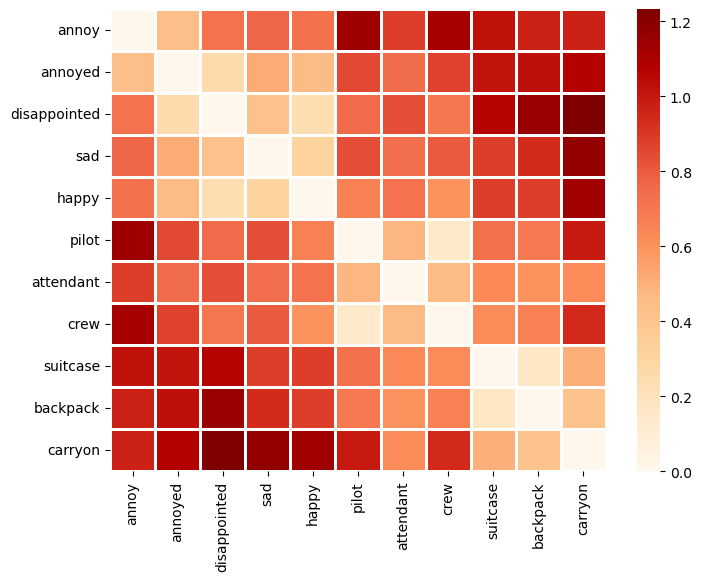

In [183]:
plt.figure(figsize=(8,6))
#sns.color_palette("viridis", as_cmap=True)
sns.color_palette("mako", as_cmap=True)
sns.heatmap(
    pairwise_top,
    #cmap='BuPu', #'OrRd',
    cmap='OrRd',
    linewidth=1
)

In [184]:
data_URL = 'https://raw.githubusercontent.com/sgeinitz/CS39AA/main/data/trainA.csv'
df = pd.read_csv(data_URL)
print(f"df.shape: {df.shape}")
pd.set_option("display.max_colwidth", 240)
df.head(10)

df.shape: (10000, 2)


,sentiment,text
0,positive,@JetBlue @JayVig I like the inflight snacks! I'm flying with you guys on 2/28! #JVMChat
1,positive,@VirginAmerica thanks guys! Sweet route over the Rockies #airplanemodewason
2,negative,@USAirways Your exchange/credit policies are worthless and shadier than the White House. Dissatisfied to the nines right now.
3,negative,@USAirways but in the meantime I'll be sleeping on a park bench on dadeland st. Thanks guys!
4,negative,@VirginAmerica hold times at call center are a bit much
5,negative,@USAirways not moving we are in the tarmac delayed for some unknown reason. I'll keep you posted
6,neutral,"@JetBlue What about if I booked it through Orbitz? My email is correct, but there's a middle party."
7,negative,@united 2nd flight also delayed no pilots! But they boarded is so we can just sit here! #scheduling
8,negative,".@AmericanAir after 50 minutes on hold, and another 30 minutes on the call yes. Going to be pushing it to get to the airport on time now"
9,positive,@JetBlue flight 117. proud to fly Jet Blue!


Recall that about 2/3 of the data have negative labels, and that the remaining labels are roughly split between positive and neutral (slightly more neutral than positive). 

In [185]:
random.seed(42) 
indices = list(range(len(df)))
random.shuffle(indices)

df_test = df.iloc[indices[9000:],]
df = df.iloc[indices[:9000],]

In [186]:
df.sentiment.value_counts(normalize=False)

negative    5868
neutral     1726
positive    1406
Name: sentiment, dtype: int64

Let's start with the nltk TweetTokenizer, which will split the text into separate words and characters based on common Twitter conventions. 

In [187]:
import torchtext
from torchtext.data import get_tokenizer
tokenizer = get_tokenizer("basic_english") # "basic_english"   "subword" uses revtok module (but does not work with GLoVE)
df['tokens_raw'] = df['text'].apply(lambda x: tokenizer(x.lower()))
df.head()

,sentiment,text,tokens_raw
3771,neutral,@JetBlue Come on and provide service from Destin- Fort Walton Beach Airport,"[@jetblue, come, on, and, provide, service, from, destin-, fort, walton, beach, airport]"
6672,positive,@JetBlue u the real MVP http://t.co/jWL26G6lRw,"[@jetblue, u, the, real, mvp, http, //t, ., co/jwl26g6lrw]"
7261,negative,"@SouthwestAir My brother &amp; his girlfriend’s flight Cancelled Flightled 3 times, now leaving 72 hours Late Flight and dropping letter grades at school. Help?","[@southwestair, my, brother, &amp, his, girlfriend’s, flight, cancelled, flightled, 3, times, ,, now, leaving, 72, hours, late, flight, and, dropping, letter, grades, at, school, ., help, ?]"
760,neutral,@AmericanAir More or less - after a night in a party hotel - no sleep and a 5:30 am rebook- on our way back to PHL http://t.co/4G0K0z2rei,"[@americanair, more, or, less, -, after, a, night, in, a, party, hotel, -, no, sleep, and, a, 5, 30, am, rebook-, on, our, way, back, to, phl, http, //t, ., co/4g0k0z2rei]"
3779,neutral,@JetBlue marks 15th birthday with 'Blumanity' paint job - @Dallas_News (blog) http://t.co/lFGR0Nifut,"[@jetblue, marks, 15th, birthday, with, ', blumanity, ', paint, job, -, @dallas_news, (, blog, ), http, //t, ., co/lfgr0nifut]"


We can now look at the emebedding for each individual token in a single tweet. Notice that when a token does not exist in GloVE that it is assigned all zeros. 

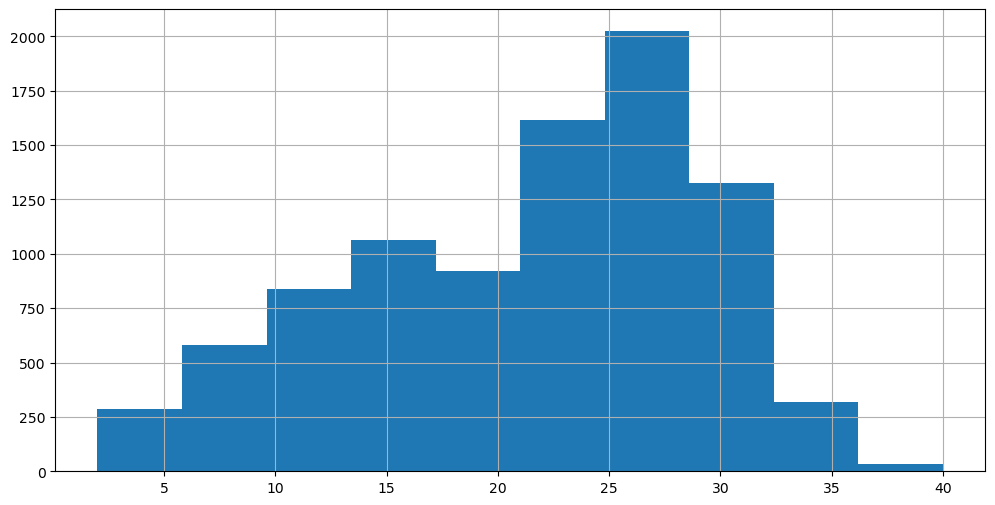

In [188]:
df['tweet_length'] = df['tokens_raw'].apply(lambda x: len(x))
plt.figure(figsize=(12,6))
df['tweet_length'].hist() #bins=100, range=(0,45), width=0.9) #, df['tweet_length'].mean(), df['tweet_length'].median()
plt.show()

In [189]:
tweet_i= 65
tweet_embeddings = vec.get_vecs_by_tokens(df['tokens_raw'][tweet_i], lower_case_backup=True)
print(f"sentiment of this tweet: {df['sentiment'][tweet_i]}")
print(f"tweet_embeddings.shape = {tweet_embeddings.shape}")
for i in range(df['tweet_length'][tweet_i]):
    print(f"    token, '{df['tokens_raw'][tweet_i][i]}' (at pos {i:2.0f}) has tweet_embeddings[:5] = {tweet_embeddings[i][:5]}")

sentiment of this tweet: negative
tweet_embeddings.shape = torch.Size([15, 50])
    token, '@usairways' (at pos  0) has tweet_embeddings[:5] = tensor([0., 0., 0., 0., 0.])
    token, 'no' (at pos  1) has tweet_embeddings[:5] = tensor([ 0.3496,  0.4015, -0.0126,  0.1374,  0.4008])
    token, 'my' (at pos  2) has tweet_embeddings[:5] = tensor([-0.2728,  0.7752, -0.1018, -0.9166,  0.9048])
    token, 'flight' (at pos  3) has tweet_embeddings[:5] = tensor([ 1.7306,  0.2840, -0.0406, -0.0874, -0.4819])
    token, 'plans' (at pos  4) has tweet_embeddings[:5] = tensor([ 1.3427, -0.0681,  0.5598,  0.2806, -0.5117])
    token, 'have' (at pos  5) has tweet_embeddings[:5] = tensor([ 0.9491, -0.3497,  0.4812, -0.1931, -0.0088])
    token, 'been' (at pos  6) has tweet_embeddings[:5] = tensor([ 0.9288, -0.7246,  0.0681, -0.3816, -0.0387])
    token, 'delayed' (at pos  7) has tweet_embeddings[:5] = tensor([ 1.0818, -0.3236,  0.0523,  0.2775, -1.1769])
    token, 'until' (at pos  8) has tweet_embeddin

In [190]:
tweet_embeddings.shape

torch.Size([15, 50])

Before we continue we must decide what a good length will be for a max-length of the number of tokens to keep. Let's look at a histogram of the lenghts of each tweet (where length equals the number of raw tokens).

In [191]:
def meanTweetEmbeddings(raw_tokens):
    embeddings = vec.get_vecs_by_tokens(raw_tokens, lower_case_backup=True)
    n_embs = 0
    emb_sum = torch.zeros((embeddings.shape[1]))
    for i in range(min(embeddings.shape[0], 35)):
        if embeddings[i].abs().sum() > 0:
            n_embs += 1
            emb_sum += embeddings[i]
    if n_embs > 0:
        emb_avg = emb_sum / n_embs
    else:
        emb_avg = torch.zeros((embeddings.shape[1]))
    if np.any(np.isnan(emb_avg.numpy())):
        print(f"exists an nan: {emb_sum}")
    return emb_avg

#X_int = df['tokens_raw'].apply(lambda x: meanTweetEmbeddings(x)).values
#X_int[:5]

In [192]:
# an alternative to the above is to stack the first k tokens in a tweet together so that we keep the 
# original embeddings, the disadvantage being that we are dropping all the tokens after the kth one
def lineup_k_TweetEmbeddings(raw_tokens, k = 25):
    embeddings = vec.get_vecs_by_tokens(raw_tokens, lower_case_backup=True)
    #n_embs = 0
    emb_stacked = torch.zeros((k, embeddings.shape[1]))
    j = 0
    for i in range(min(embeddings.shape[0], k)):
        if embeddings[i].abs().sum() <= 1e-3:
            continue
        else:
            emb_stacked[j] = embeddings[i]
            j += 1
    if np.any(np.isnan(emb_stacked.numpy())):
        print(f"exists an nan: {emb_stacked}")
    return emb_stacked.flatten()

#X_int = df['tokens_raw'].apply(lambda x: lineup_k_TweetEmbeddings(x)).values

In [193]:
# the embeddings will be in a tuple of tensors, so we need to stack them into a single tensor
torch.stack(tuple(X_int)).size()

torch.Size([9000, 50])

In [194]:
# alternatively, we could sum up the embeddings for each token in a tweet (then we don't have worry about a max length)
def sum_Tweet_Embeddings(raw_tokens):
    embeddings = vec.get_vecs_by_tokens(raw_tokens, lower_case_backup=True)
    n_embs = 0
    emb_sum = torch.zeros((embeddings.shape[1]))
    for i in range(embeddings.shape[0]):
        if embeddings[i].abs().sum() > 0:
            n_embs += 1
            emb_sum += embeddings[i]
    if n_embs > 0:
        emb_avg = emb_sum / n_embs
    else:
        emb_avg = torch.zeros((embeddings.shape[1]))
    if np.any(np.isnan(emb_avg.numpy())):
        print(f"exists an nan: {emb_sum}")
    return emb_avg

X_int = df['tokens_raw'].apply(lambda x: sum_Tweet_Embeddings(x)).values

In [195]:
X_int.shape # one tweet will now be represented by a single rank-one 50-element tensor

(9000,)

In [196]:
if len(X_int[0] > 50):
    avg_embedding = False    
else:
    avg_embedding = True

X = torch.stack(tuple(X_int))
X.shape
#X[:2]

torch.Size([9000, 50])

There should be 9000 rows in X, since this is the number of tweets (i.e. observations) in the training data. 

The number of columns is the _embedding size_ times the number of max number of tokens we'll keep for each tweet. In this case, keeping 25 means that the number of columns will be:
*  50 * 25  -->  1250.  

In [197]:
labels = df['sentiment'].unique()
enum_labels = enumerate(labels)
label_to_idx = dict((lab, i) for i,lab in enum_labels)
print(f"label dictionary: {label_to_idx}")
y = torch.tensor([label_to_idx[lab] for lab in df['sentiment']])

label dictionary: {'neutral': 0, 'positive': 1, 'negative': 2}


In [198]:
y[:10]

tensor([0, 1, 2, 0, 0, 2, 2, 2, 0, 1])

In [199]:
# Can be a good idea to occassionally check that the dims (or shapes) agree for the inputs (X) and labels (y)
assert len(X) == len(y)

In [200]:
class AirlineTweetDataset(Dataset):
    def __init__(self, observations, labels):
        self.obs = observations
        self.labs = labels
        self.create_split(len(observations))

    def create_split(self, n, seed=2, train_perc=0.7):
        random.seed(seed)
        indices = list(range(n))
        random.shuffle(indices)
        self._train_ids = list(indices[:int(n * train_perc)])
        self._test_ids = list(indices[int(n * train_perc):])
        self._split_X = self.obs[self._train_ids]
        self._split_y = self.labs[self._train_ids]

    def set_split(self, split='train'):
        if split == 'train':
            self._split_X = self.obs[self._train_ids]
            self._split_y = self.labs[self._train_ids]
        else:
            self._split_X = self.obs[self._test_ids]
            self._split_y = self.labs[self._test_ids]

    def __len__(self):
        return len(self._split_y)

    def __getitem__(self, idx):
        return {'x':self._split_X[idx], 'y':self._split_y[idx]}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

dataset = AirlineTweetDataset(X, y)
dataset.create_split(len(X), seed=42, train_perc=0.85)

In [201]:
dataset.set_split('train')
print(f"len(dataset) = {len(dataset)}")
#len(dataset[:]['x'])
dataset[0]['x']

len(dataset) = 7650


tensor([ 0.2755,  0.3532,  0.1414, -0.0719,  0.2755,  0.0436, -0.4410, -0.0756,
        -0.1834, -0.1497, -0.0589,  0.1035, -0.5399, -0.0845,  0.6077,  0.1494,
        -0.1089,  0.0532, -0.5013, -0.3242, -0.0101,  0.3278,  0.2874,  0.0467,
         0.3526, -1.5300, -0.3083,  0.2123,  0.4151, -0.3225,  3.1063,  0.2745,
        -0.2358, -0.1187,  0.0452, -0.1378,  0.3318,  0.0707,  0.1511,  0.0235,
        -0.1112,  0.0702,  0.0894,  0.2073, -0.2028, -0.0087, -0.0561, -0.1535,
         0.0571,  0.1092])

In [202]:
assert not np.any(np.isnan(dataset[:]['x'].numpy()))
assert np.all(np.isfinite(dataset[:]['x'].numpy()))

In [203]:
class AirlineTweetClassifier(nn.Module):
    """ A 2-layer Multilayer Perceptron for classifying surnames """
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Args:
            input_dim (int): the size of the input embeddings
            hidden_dim (int): the output size of the first Linear layer
            output_dim (int): the output size of the second Linear layer
        """
        super(AirlineTweetClassifier, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 32)
        self.fc3 = nn.Linear(32, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        intermediate_vector = F.relu(self.fc1(x_in))

        intermediate_vector = F.relu(self.fc2(intermediate_vector))
        intermediate_vector = self.dropout(intermediate_vector)

        prediction_vector = self.fc3(intermediate_vector)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

In [204]:
batch_size = 64
learning_rate = 0.0005 # 0.005
num_epochs = 30

device = 'cpu'
#device = torch.device('cuda' if torch.backend.mps.is_available() else 'cpu')

dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [205]:
dataset.set_split('train')
print(len(dataloader) * batch_size)
dataset.set_split('val')
print(len(dataloader) * batch_size)

7680
1408


In [206]:
model = AirlineTweetClassifier(len(dataset[0]['x']), 128, 3)

# define loss function and optimizer
#weights = 1 / torch.tensor([15.0, 65.0, 20.0])
loss_fun = nn.CrossEntropyLoss()#weights)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [207]:
seed = 2
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

In [208]:
import tqdm.auto

epoch_bar = tqdm.notebook.tqdm(desc='training routine', total=num_epochs, position=0)

dataset.set_split('train')
train_bar = tqdm.notebook.tqdm(desc='split=train', total=dataset.get_num_batches(batch_size), position=1, leave=True)

dataset.set_split('val')
val_bar = tqdm.notebook.tqdm(desc='split=val', total=dataset.get_num_batches(batch_size), position=1, leave=True)

losses = {'train':[], 'val':[]}

for epoch in range(num_epochs):

    dataset.set_split('train')
    model.train()
    running_loss_train = 0.0

    for batch_i, batch_data in enumerate(dataloader):  
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)
        
        # forward
        outputs = model(tweets)
        loss = loss_fun(outputs, labels)
        losses['train'].append(loss.item())
        running_loss_train += loss.item() #/ batch_size
        	
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        		
        #if (batch_i+1) % 10 == 0:
        #    print(f"    train batch {batch_i+1:3.0f} (of {len(dataloader):3.0f}) loss: {loss.item():.4f}")
            # update bar
        train_bar.set_postfix(loss=running_loss_train, epoch=epoch)
        train_bar.update()

    train_bar.set_postfix(loss=running_loss_train/dataset.get_num_batches(batch_size), epoch=epoch)
    train_bar.update()

    #running_loss_train = running_loss_train / len(dataset)

    dataset.set_split('val')
    model.eval() # turn off the automatic differentiation 
    running_loss_val = 0.0

    for batch_i, batch_data in enumerate(dataloader):  
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)
        
        # forward (no backward step for validation data)
        outputs = model(tweets)
        loss = loss_fun(outputs, labels)
        losses['val'].append(loss.item())
        running_loss_val += loss.item() #/ batch_size
        #if (batch_i+1) % 20 == 0:
        #    print(f"    valid batch {i+1:3.0f} (of {len(dataloader):3.0f}) loss: {loss.item():.4f}")
        val_bar.set_postfix(loss=running_loss_val, epoch=epoch)
        val_bar.update()

    val_bar.set_postfix(loss=running_loss_val/dataset.get_num_batches(batch_size), epoch=epoch)
    val_bar.update()


    train_bar.n = 0
    val_bar.n = 0
    epoch_bar.update()

    #running_loss_val = running_loss_val / len(dataset)

    #print(f"Epoch {epoch+1} (of {num_epochs}): mean train loss = {running_loss_train:.4f}, mean val loss = {running_loss_val:.4f}")

training routine:   0%|          | 0/30 [00:00<?, ?it/s]

split=train:   0%|          | 0/119 [00:00<?, ?it/s]

split=val:   0%|          | 0/21 [00:00<?, ?it/s]

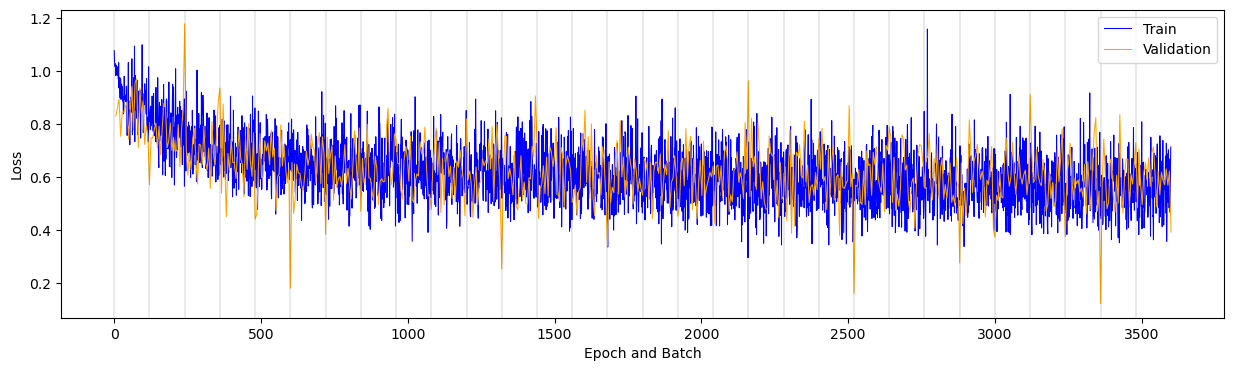

In [209]:
matplotlib.rc('figure', figsize=(15,4))
val_ticks = [(i+1)*len(losses['train'])/len(losses['val']) for i in range(len(losses['val']))]
plt.plot(range(len(losses['train'])), losses['train'], c='blue', lw=0.75)
plt.plot(val_ticks, losses['val'], c='orange', lw=0.75)
for i in range(num_epochs):
    plt.axvline(x=i*len(losses['train'])/num_epochs, c='black', lw=0.25, alpha=0.5)
plt.ylabel('Loss')
plt.xlabel('Epoch and Batch')
plt.legend(('Train','Validation'))

In [210]:
dataset.set_split('val')
len(dataset)

1350

In [211]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
y_true = []
y_pred = []

dataset.set_split('val')
with torch.no_grad():
    correct = 0
    total = 0
    for batch_data in dataloader:
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)
        outputs = model(tweets)
        _, predicted = torch.max(outputs.data, 1)
        y_true += labels.tolist()
        y_pred += predicted.tolist()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy (on {len(dataloader)*batch_size} validation tweets): {100 * correct / total:.2f}%")
	 

Accuracy (on 1408 validation tweets): 76.59%


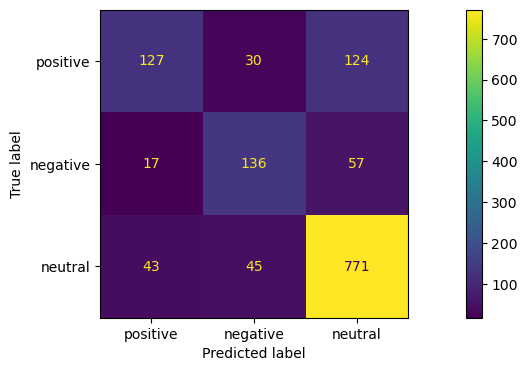

In [212]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['positive','negative','neutral'])
disp.plot()

In [213]:
# length of an input is
len(dataset[0]['x'])

50

In [214]:
import torchsummary
torchsummary.summary(model, tuple(dataset[0]['x'].size()))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           6,528
            Linear-2                   [-1, 32]           4,128
           Dropout-3                   [-1, 32]               0
            Linear-4                    [-1, 3]              99
Total params: 10,755
Trainable params: 10,755
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [215]:
df_test['tokens_raw'] = df_test['text'].apply(lambda x: tokenizer(x.lower()))
X_test_int = df_test['tokens_raw'].apply(lambda x: sum_Tweet_Embeddings(x)).values
X_test = torch.stack(tuple(X_test_int))
X_test.shape

torch.Size([1000, 50])

In [216]:
y_test = torch.tensor([label_to_idx[lab] for lab in df_test['sentiment']])

In [217]:
test_dataset = AirlineTweetDataset(X_test, y_test)
test_dataset.create_split(len(X_test), seed=42, train_perc=1.0)

In [218]:
len(test_dataset)

1000

In [219]:
test_dataset[999]

{'x': tensor([ 4.2224e-01,  1.4241e-01,  1.2053e-01, -1.7798e-03,  4.0264e-01,
         -1.3060e-01, -5.1082e-01, -1.8689e-01, -1.1695e-01, -8.3994e-02,
         -9.4942e-02,  4.1504e-01, -2.4253e-01, -1.4244e-01,  5.1127e-01,
          4.0539e-01, -5.6116e-02,  1.4513e-02,  9.3961e-02, -6.1356e-01,
          3.3893e-02,  2.3875e-01,  1.5466e-01,  1.9822e-01,  2.5455e-01,
         -1.5758e+00, -3.5155e-01,  1.2649e-01,  5.5148e-01, -5.4988e-01,
          3.1252e+00,  3.4321e-01, -4.2093e-01, -3.0634e-01, -1.2966e-01,
         -1.2857e-01,  8.4230e-04,  5.0270e-02,  1.3142e-01, -2.5790e-01,
          1.8883e-01,  1.0731e-01,  4.9320e-02,  3.1827e-01, -5.0537e-02,
          1.0613e-01,  1.8867e-02,  1.0771e-01, -6.1917e-02,  4.5576e-01]),
 'y': tensor(2)}

In [220]:
bs = 100
test_loader = DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [221]:
y_true = []
y_pred = []
with torch.no_grad():
    correct = 0
    total = 0
    for batch_data in test_loader:
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)
        outputs = model(tweets)
        _, predicted = torch.max(outputs.data, 1)
        y_true += labels.tolist()
        y_pred += predicted.tolist()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy (on {len(test_loader)*bs} test tweets): {100 * correct / total:.2f}%")

Accuracy (on 1000 test tweets): 77.30%


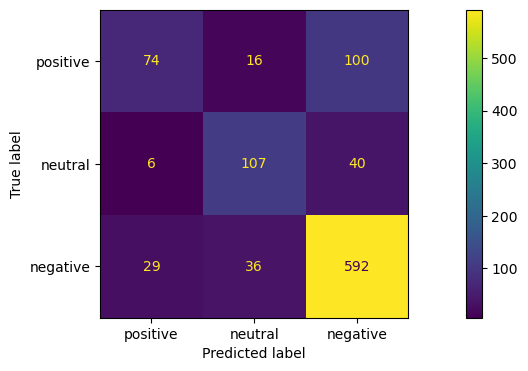

In [222]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['positive','neutral','negative'])
disp.plot()